<a href="https://colab.research.google.com/github/flamemeister/QazQa/blob/main/create_kaz5_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers sentencepiece

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("google/mt5-large")

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('google/mt5-large')

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


In [ ]:
print(tokenizer.vocab_size)

250100


In [ ]:
def msize(m):
    return sum(p.numel() for p in m.parameters())

original_size = msize(model)
print(msize(model))
print(msize(model.shared))
print('encoder')
print(msize(model.encoder))
print(msize(model.encoder.block))
print('decoder')
print(msize(model.decoder))
print(msize(model.decoder.block))
print(msize(model.lm_head))

1229581312
256114688
encoder
564446720
308331008
decoder
665134592
409018880
256114688


Input and output embeddings are 66% of the whole model

In [ ]:
print(msize(model.shared) / msize(model))
print(msize(model.lm_head) / msize(model))

0.2082942262544732
0.2082942262544732


In [ ]:
!wget http://pcai056.informatik.uni-leipzig.de/downloads/corpora/eng-com_web-public_2018_1M.tar.gz
!tar -xsvf eng-com_web-public_2018_1M.tar.gz

In [ ]:
import pandas as pd
pd.options.display.max_colwidth = 300
import csv
fname = 'kaz_news_2020_10K/kaz_news_2020_10K-sentences.txt'
df_kaz = pd.read_csv(fname, sep='\t', header=None, quoting=csv.QUOTE_NONE)
df_kaz.columns = ['idx', 'text']
df_kaz.sample(5)

,idx,text
8412,8413,Серіктің келіншегі – Тұрсынзада күніне әр сиырдан 10 литр сүт алады.
3153,3154,"Әйтпесе бәрінде бірдей тегін машинасы да, тіге алатын өнер де жоқ."
9622,9623,"Үкіметке жыл сайын әлемнің жетекші ғылыми орталықтарында 500 ғалымның тағылымдамадан өтуін қамтамасыз етуді, сондай-ақ, «Жас ғалым» жобасы аясында зерттеу жүргізу үшін 1000 грант бөлуді тапсырамын."
4856,4857,"Қазір құс фабрикасына келген шығын сомасы 554,7 млн теңгеге жетті."
6626,6627,"Нұр-Сұлтан қаласында орналасқан шет мемлекеттердің дипломатиялық өкілдіктері мен халықаралық ұйымдарға қатысты туындаған мәселелерді тез арада шешіп, тиісті көмек көрсету керектігін айтты."


In [ ]:
from collections import Counter
from tqdm.auto import tqdm, trange

cnt_kaz = Counter()
for text in tqdm(df_kaz.text):
    cnt_kaz.update(tokenizer.encode(text))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
print(len(cnt_kaz), len(cnt_kaz)/tokenizer.vocab_size)

7943 0.0317592962814874


In [ ]:
print('kaz')
for top in 10_000, 20_000, 30_000:
    print(top, sum(v for k, v in cnt_kaz.most_common(top)) / sum(cnt_kaz.values()))

kaz
10000 1.0
20000 1.0
30000 1.0


Remember the old vocabulary, because we are going to replace it soon!

In [ ]:
old_voc = tokenizer.get_vocab()
old_inv_voc = {v: k for k, v in old_voc.items()}

Look at the most used tokens. They are mostly service words or prefixes.

In [ ]:
print(tokenizer.convert_ids_to_tokens([k for k, v in cnt_kaz.most_common(1000)]))

['▁', '</s>', '.', ',', 'у', '-', 'і', 'ы', 'а', 'п', 'ге', 'ға', 'ды', '▁«', '▁бар', 'е', '▁бір', 'ған', '▁және', '▁ж', 'лық', 'ын', 'м', 'ып', 'сы', 'ді', 'іп', 'й', '▁–', '▁О', 'інде', '▁жұмыс', '▁мен', '»', 'ның', 'да', '▁да', 'ң', '▁бол', '▁де', 'де', 'ты', '▁с', 'т', 'қа', 'үшін', 'р', 'мен', 'уға', '▁бас', 'н', 'ында', 'ақ', '▁жыл', 'ін', '▁қала', 'ке', 'Бұл', 'с', '▁қызмет', '▁адам', '▁А', '▁өз', '▁со', '▁Со', 'тар', '▁Б', '▁к', '▁қа', 'ейін', 'еді', '▁қара', '▁Қо', 'дан', '▁бер', '▁күн', 'інің', '▁обл', 'лар', '▁тұрғ', '▁бойынша', '▁ар', 'л', 'ны', '▁жағдай', '▁баста', '▁отыр', 'та', '▁айт', '▁Ал', 'ғы', 'лік', '▁ал', '▁ел', '▁тең', '▁д', 'дық', '▁от', '▁жол', 'дағы', 'аудан', 'стана', 'ті', '▁деп', 'и', 'іне', 'ш', '▁Е', '▁мы', '▁бұл', '▁б', 'ден', '▁Ж', '▁жер', 'ша', 'осы', 'ір', '▁өт', 'гі', 'атын', 'лардың', '▁қам', 'на', 'ндай', 'қ', 'ен', '▁әк', 'ады', '▁Ә', 'уге', '▁—', 'ының', 'ына', 'з', '▁керек', '▁көп', '▁туралы', 'алық', '▁жаса', '▁у', '▁Қазақстан', 'о', '▁орта', '

In [ ]:
new_tokens = set(range(10000))
for i, (k, v) in enumerate(cnt_kaz.most_common(10_000)):
    if k not in new_tokens:
        new_tokens.add(k)

for t in range(tokenizer.vocab_size - 100, tokenizer.vocab_size):
    new_tokens.add(t)

print(len(new_tokens))
kept_ids = sorted(new_tokens)

17082


The new vocabulary is only 12% of the original one. 

In [ ]:
len(kept_ids) / tokenizer.vocab_size

0.06830067972810876

The plot shows that the tokens that were more frequent in the original vocabulary more frequently get into the new vocabulary (so that the curve bends upward). 

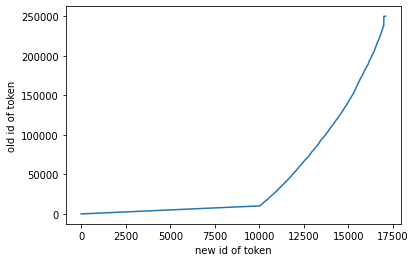

In [ ]:
import matplotlib.pyplot as plt
plt.plot(kept_ids)
plt.xlabel('new id of token')
plt.ylabel('old id of token');

### Update the embeddings

In [ ]:
import torch

In [ ]:
new_size = len(kept_ids)
new_emb = torch.nn.Embedding(new_size, model.shared.embedding_dim)
new_head = torch.nn.Linear(in_features=model.lm_head.in_features, out_features=new_size, bias=False)

In [ ]:
for new_id, old_id in enumerate(kept_ids):
    new_emb.weight.data[new_id] = model.shared.weight.data[old_id]
    new_head.weight.data[new_id] = model.lm_head.weight.data[old_id]

In [ ]:
model.shared.weight = new_emb.weight
model.lm_head.weight = new_head.weight

The new model has 244M parameters - 42% of the original size. 

In [ ]:
print(msize(model), msize(model) / original_size)

752335872 0.6118634568187061


### Update the tokenizer

T5 uses Sentencepiece tokenizer, which is implemented in C and is opaque to Python. 

Fortunately, we can download its model and deploy it into Python using its Protobuf representation. 

https://github.com/google/sentencepiece/issues/121

In [ ]:
!wget https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto

--2023-02-24 07:07:45--  https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13451 (13K) [text/plain]
Saving to: ‘sentencepiece_model.proto’

sentencepiece_model 100%[===================>]  13.14K  --.-KB/s    in 0s      

2023-02-24 07:07:45 (104 MB/s) - ‘sentencepiece_model.proto’ saved [13451/13451]



In [ ]:
! protoc --python_out=. sentencepiece_model.proto

In [ ]:
import sentencepiece_model_pb2 as spmp
smp = tokenizer.sp_model.serialized_model_proto()
m = spmp.ModelProto()
m.ParseFromString(smp)

print('the loaded model has pieces:', len(m.pieces))
new_pieces = [m.pieces[idx] for idx in kept_ids]
print('the new pieces:', len(new_pieces))

# replace the content of the first 30K pieces
for i, p in enumerate(new_pieces):
    m.pieces[i].piece = p.piece
    m.pieces[i].score = p.score
    m.pieces[i].type = p.type

# drop the remaining pieces
n = len(new_pieces)
for i in trange(len(m.pieces) - n):
    m.pieces.pop(len(m.pieces) - 1)

print(len(m.pieces))
with open('new_sp.model', 'wb') as f:
    f.write(m.SerializeToString())

the loaded model has pieces: 250100
the new pieces: 17082


  0%|          | 0/233018 [00:00<?, ?it/s]

17082


In [ ]:
new_tokenizer = T5Tokenizer('new_sp.model', extra_ids=0)

### Save the model

In [ ]:
model.config.__dict__['vocab_size'] = new_size
model.config.__dict__['_name_or_path'] = 'cointegrated/kaz5-base-large'
model.config

T5Config {
  "_name_or_path": "cointegrated/kaz5-base-large",
  "architectures": [
    "MT5ForConditionalGeneration"
  ],
  "d_ff": 2816,
  "d_kv": 64,
  "d_model": 1024,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 24,
  "num_heads": 16,
  "num_layers": 24,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "transformers_version": "4.26.1",
  "use_cache": true,
  "vocab_size": 17082
}

In [ ]:
new_tokenizer.save_pretrained('kaz5-base-large')
model.save_pretrained('kaz5-base-large')

In [ ]:
!ls kaz5-base-large -alsh

total 2.9G
4.0K drwxr-xr-x 2 root root 4.0K Feb 24 07:40 .
4.0K drwxr-xr-x 1 root root 4.0K Feb 24 07:40 ..
4.0K -rw-r--r-- 1 root root  809 Feb 24 07:40 config.json
4.0K -rw-r--r-- 1 root root  142 Feb 24 07:40 generation_config.json
2.9G -rw-r--r-- 1 root root 2.9G Feb 24 07:40 pytorch_model.bin
4.0K -rw-r--r-- 1 root root   74 Feb 24 07:40 special_tokens_map.json
536K -rw-r--r-- 1 root root 535K Feb 24 07:40 spiece.model
4.0K -rw-r--r-- 1 root root  245 Feb 24 07:40 tokenizer_config.json


Now try to load the model

In [ ]:
model1 = T5ForConditionalGeneration.from_pretrained('kaz5-base-large')
tokenizer1 = T5Tokenizer.from_pretrained('kaz5-base-large')

In [ ]:
inputs = tokenizer1('Менің <extra_id_0> Курмаш.', return_tensors='pt')
with torch.no_grad():
    hypotheses = model1.generate(
        **inputs, 
        do_sample=True, top_p=0.95, 
        num_return_sequences=3, 
        repetition_penalty=2.5,
        max_length=32,
    )
for h in hypotheses:
    print(tokenizer1.decode(h))

<pad><extra_id_0> Сайтымның <extra_id_1> Сайтылым. Пейтап барам. Украина. Не работает Автосервисы <extra_id_15> сайтың: Менің Бизнес
<pad><extra_id_0> Атының порталы <extra_id_1> ательемін <extra_id_15> астам менгемелері. Интернет-радиофирма <extra_id_16> Атамды қаражаттандыруын сату бойынша
<pad><extra_id_0> барш: ТК <extra_id_1> менсін. <extra_id_15> б-м. Фотогалерея, картина "Ревю" на фото <extra_id_16> көрген


In [ ]:
from google.colab import drive
drive.mount('/gd')

Drive already mounted at /gd; to attempt to forcibly remount, call drive.mount("/gd", force_remount=True).


In [ ]:
model1.save_pretrained('/gd/MyDrive/models/kaz5-base-large-raw')
tokenizer1.save_pretrained('/gd/MyDrive/models/kaz5-base-large-raw')

('/gd/MyDrive/models/kaz5-base-large-raw/tokenizer_config.json',
 '/gd/MyDrive/models/kaz5-base-large-raw/special_tokens_map.json',
 '/gd/MyDrive/models/kaz5-base-large-raw/spiece.model',
 '/gd/MyDrive/models/kaz5-base-large-raw/added_tokens.json')